In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_theme()
plt.rcParams['figure.figsize'] = [8,8]

In [4]:
sharks = pd.read_csv("sharks.csv")
sharks

,Species,Length,Weight,Category
0,Acroteriobatus annulatus,140.0,20463.398751,Vulnerable
1,Acroteriobatus blochii,100.0,8302.228700,Least Concern
2,Acroteriobatus leucospilus,120.0,13535.898740,Endangered
3,Acroteriobatus salalah,78.0,4264.716085,Near Threatened
4,Acroteriobatus variegatus,75.0,3839.035532,Critically Endangered
...,...,...,...,...
804,Urotrygon simulatrix,26.7,240.778211,Vulnerable
805,Urotrygon venezuelae,25.5,212.849595,Endangered
806,Zameus squamulosus,84.0,5202.119234,Least Concern
807,Zapteryx brevirostris,53.4,758.000000,Endangered


In [5]:
threatened = ["Critically Endangered","Endangered","Vulnerable"]

In [6]:
sharks["Threatened"] = sharks["Category"].isin( threatened ).astype('int')
sharks = sharks.drop(columns = "Category")
sharks

,Species,Length,Weight,Threatened
0,Acroteriobatus annulatus,140.0,20463.398751,1
1,Acroteriobatus blochii,100.0,8302.228700,0
2,Acroteriobatus leucospilus,120.0,13535.898740,1
3,Acroteriobatus salalah,78.0,4264.716085,0
4,Acroteriobatus variegatus,75.0,3839.035532,1
...,...,...,...,...
804,Urotrygon simulatrix,26.7,240.778211,1
805,Urotrygon venezuelae,25.5,212.849595,1
806,Zameus squamulosus,84.0,5202.119234,0
807,Zapteryx brevirostris,53.4,758.000000,1


In [7]:
sharks["LogWeight"] = np.log(sharks["Weight"])
sharks_model = smf.glm("Threatened ~ LogWeight", data=sharks, family=sm.families.Binomial())
sharks_fit = sharks_model.fit()
sharks_fit.params

Intercept   -3.173571
LogWeight    0.293120
dtype: float64

In [8]:
1 - chi2.cdf(sharks_fit.null_deviance - sharks_fit.deviance, df=1)

8.770761894538737e-15

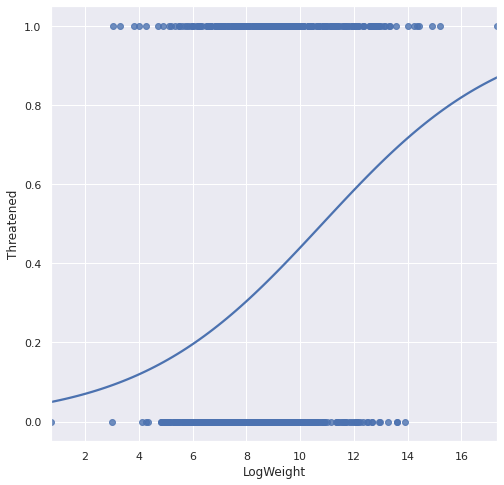

In [9]:
sns.regplot(data=sharks, x="LogWeight", y="Threatened", logistic=True, ci=None)
plt.savefig("sharks_fit.png")

In [10]:
sharks["Class"] = (sharks_fit.fittedvalues > 0.50).astype(int)
sharks

,Species,Length,Weight,Threatened,LogWeight,Class
0,Acroteriobatus annulatus,140.0,20463.398751,1,9.926393,0
1,Acroteriobatus blochii,100.0,8302.228700,0,9.024279,0
2,Acroteriobatus leucospilus,120.0,13535.898740,1,9.513101,0
3,Acroteriobatus salalah,78.0,4264.716085,0,8.358131,0
4,Acroteriobatus variegatus,75.0,3839.035532,1,8.252976,0
...,...,...,...,...,...,...
804,Urotrygon simulatrix,26.7,240.778211,1,5.483876,0
805,Urotrygon venezuelae,25.5,212.849595,1,5.360586,0
806,Zameus squamulosus,84.0,5202.119234,0,8.556821,0
807,Zapteryx brevirostris,53.4,758.000000,1,6.630683,0


In [11]:
pd.crosstab(sharks["Threatened"], sharks["Class"])

Class,0,1
Threatened,,
0,492,37
1,211,69


In [12]:
np.mean( sharks["Threatened"] == sharks["Class"] )

0.6934487021013597

In [13]:
fpr, tpr, thresholds = metrics.roc_curve(sharks["Threatened"], sharks_fit.fittedvalues)
chronic_auc = metrics.auc(fpr, tpr)
chronic_auc

0.6589994598973805

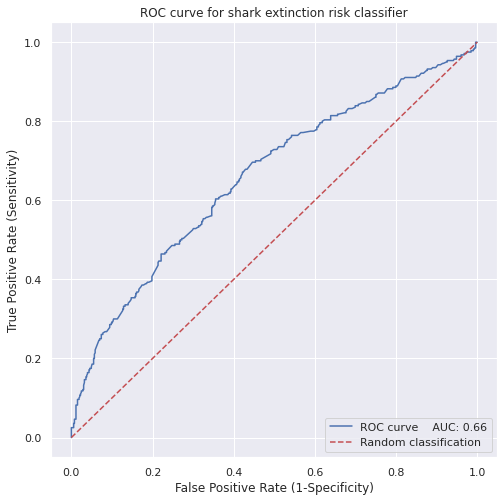

In [14]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve    AUC: %0.2f' % chronic_auc)
plt.plot([0,1], [0,1], 'r--', label='Random classification')
# plt.xlim([0, 1]) 
# plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve for shark extinction risk classifier')
plt.legend(loc="lower right")
plt.savefig("sharks_roc.png")